# Method 1: Using Pystan

I'll do this for a single n, and treat the mode locations as fixed for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)
matplotlib.rcParams['text.usetex'] = False

#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [2]:
locs = np.genfromtxt('locs.txt')
mid = int(np.floor(len(locs)/2))
l0 = locs[mid, 0]
l1 = locs[mid, 1]
l2 = locs[mid-1, 2]
l3 = locs[mid-1, 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [3]:
sel = [(ff >= 2180) & (ff <= 2280)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

In [4]:
# modelocs = np.concatenate((l0, l1, l2, l3))
modelocs = np.array([l0,l1,l2,l3])
# modeids = [0]*len(l0) + [1]*len(l1) + [2]*len(l2) + [3]*len(l3)
modeids = [0, 1, 2, 3]

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


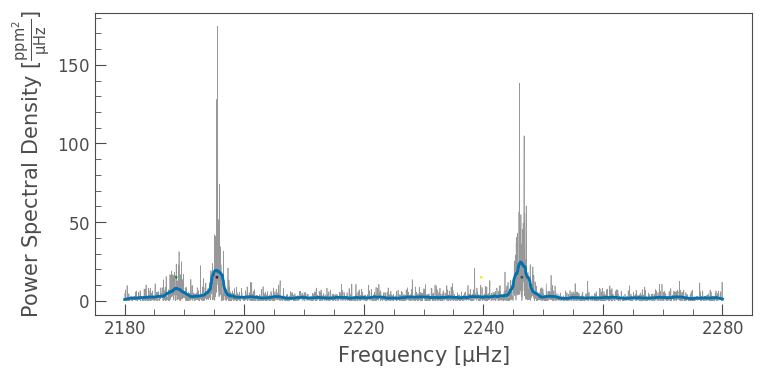

In [5]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids)
plt.show()

Lets fit a group of lorentzians to these data!

In [56]:
import pystan
import pickle
import os
overwrite = True
pbjam = '''
functions{      
    real lorentzian(real loc, int l, int m, real f, real eps, real H, real w, real nus){
        return (eps * H) / (1 + (4/w^2) * (f - loc + m*nus)^2);
    }
    real chisquared_lpdf(real x, real mu){
        return -log(2) - lgamma(1) - (x/2) - log(mu);
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    real f[N];        // Frequency
    real p[N];        // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
    int asy_ids[M];  // The ID's of the modes
}
parameters{
    real logAmp[M];      // Mode amplitude in log space
    real logGamma[M];    // Mode linewidth in log space
    real locs[M];        // True mode locations
    real<lower=0> vsini; // Line of sight rotational frequency
    real<lower=0> nus;   // Rotational frequency splitting
}
transformed parameters{
    real i;          // Angle of inclination (rad)
    real H[M];       // Mode height
    real w[M];       // Mode linewidth
    matrix[4,4] eps; // Matrix of legendre polynomials
    eps = rep_matrix(i, 4, 4);
     
    i = asin(vsini / nus); // Transform angle of inclination from line of sight rotation frequency
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
    
    // Now I'll calculate all the legendre polynomials for this i
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;
    
}
model{
    real modes[N];
    real resid[N];
    int l;

    modes = rep_array(1., N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = asy_ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            for (n in 1:N){   // Generate the value of a lorentzian for this l and m at a given f
                modes[n] += lorentzian(locs[l+1], l, m, f[n], eps[l+1,abs(m)+1], H[l+1], w[l+1], nus);
            }
        }
    }

    // Model drawn from a chi square distribution
    for (n in 1:N){
        resid[n] = modes[n] / p[n];
        resid[n] ~ chi_square(2);
    }
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1);
    logGamma ~ normal(0, 0.1);
    locs ~ normal(asy_locs, 1);
    i ~ uniform(0.1, pi()/2);
    nus ~ normal(0.411, 0.1);
}
'''
model_path = 'pbjam.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = pbjam, model_name='pbjam')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = pbjam, model_name='pbjam')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL pbjam_e88270180ed4c3584947d1142870ce2e NOW.


Updating Stan model
Reading in Stan model


In [57]:
data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'asy_locs':modelocs,
        'asy_ids':modeids}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'logGamma' : np.zeros(len(modelocs)),
        'vsini':nus*np.sin(i),
        'nus':nus,
        'locs' : modelocs}

In [58]:
nchains = 4
fit = sm.sampling(data=data, iter=1000, chains=nchains, init = [init for n in range(nchains)])

In [59]:
print(fit)

Inference for Stan model: pbjam_e88270180ed4c3584947d1142870ce2e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]    -1.24    0.03   0.42  -2.19  -1.49  -1.19  -0.94  -0.55    257   1.02
logAmp[2]     -1.0    0.02   0.42  -1.91  -1.24  -0.97   -0.7   -0.3    359   1.01
logAmp[3]    -1.18    0.02   0.41  -2.17  -1.41  -1.12  -0.89  -0.51    437   1.01
logAmp[4]    -1.48    0.02    0.4  -2.46  -1.73  -1.44  -1.19  -0.83    370   1.01
logGamma[1]  -0.02  4.7e-3    0.1  -0.21  -0.09  -0.02   0.05   0.16    448    1.0
logGamma[2]  -0.02  5.7e-3    0.1  -0.22  -0.09  -0.02   0.04   0.18    319   1.01
logGamma[3]-7.5e-3  5.0e-3    0.1  -0.21  -0.07-10.0e-3   0.06   0.21    427    1.0
logGamma[4]-5.4e-3  4.6e-3    0.1  -0.19  -0.07-7.6e-3   0.06    0.2    471   1.01
locs[1]     2195.0    0.05   0.86 2193.4 2194.5 2195.0 2195.6 2196.7  

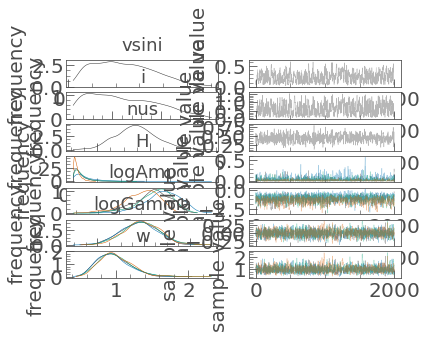

In [60]:
fit.plot(pars=['vsini','i','nus','H','logAmp','logGamma','w'])
plt.show()

In [66]:
truths= [init['vsini'],init['nus']]

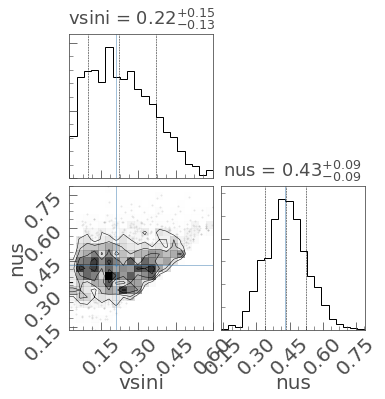

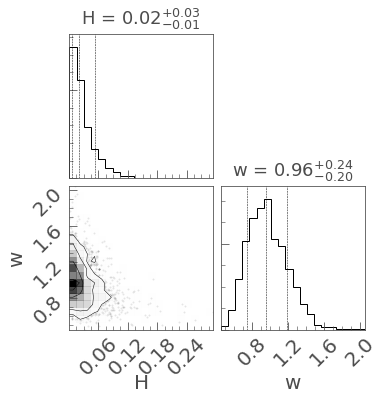

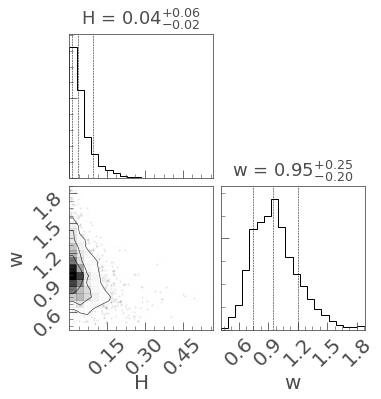

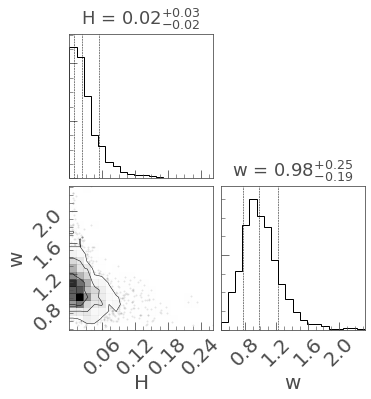

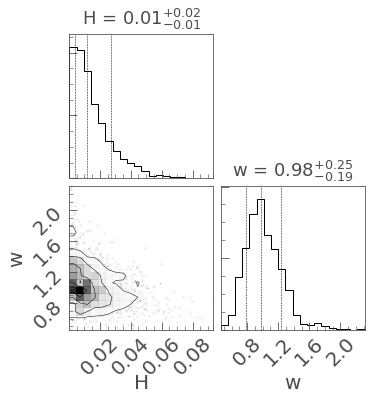

In [67]:
labels=['vsini','nus']
chain = np.array([fit[labels[0]], fit[labels[1]]])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

chain = np.array([fit['H'].T[0], fit['w'].T[0]])
corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

chain = np.array([fit['H'].T[1], fit['w'].T[1]])
corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

chain = np.array([fit['H'].T[2], fit['w'].T[2]])
corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

chain = np.array([fit['H'].T[3], fit['w'].T[3]])
corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

In [63]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
i = np.median(fit['i'])
nus = np.median(fit['nus'])
for mode in range(len(modeids)-2):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[mode])
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, modelocs[mode], i, H, w, nus)
fitlocs = np.median(fit['locs'],axis=0)

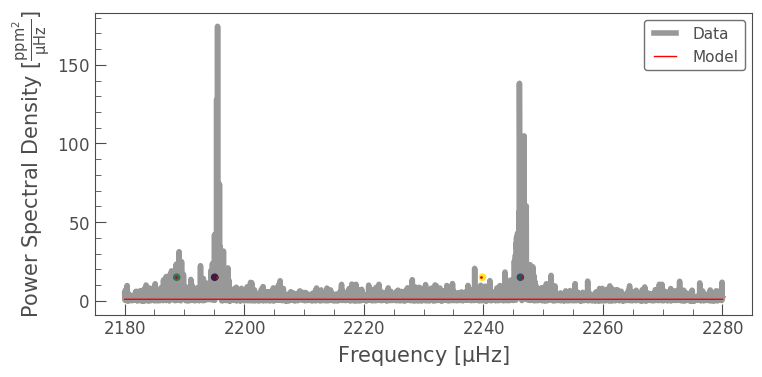

In [71]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data',linewidth=4)
plt.scatter(fitlocs, [15]*len(fitlocs),c=modeids,s=20)
plt.scatter(modelocs, [15]*len(modelocs),c='r')
plt.plot(f, model, linewidth=1, label='Model',c='r')
plt.legend()